#  <span style="color:blue">AutoML com Pycaret</span>

In [1]:
from pycaret.regression import *
import pandas as pd
import seaborn as sns
import numpy as np

# DATA ANALYSIS

#### Carregando os dados.

In [3]:
df_in_train = pd.read_parquet('dataset/df_in_train.parquet')
df_in_test = pd.read_parquet('dataset/df_in_test.parquet')

In [27]:
import hashlib

def md5hash(s: str): 
    return hashlib.md5(s.encode('utf-8')).hexdigest() # or SHA, ...

#df_in_train['id'] = df_in_train['id'].apply(md5hash)
 

In [4]:
df_in_train = df_in_train[[ 'segment','sub_segment', 'sells_volume',
                            'score', 'qty_stores']]

In [5]:
df_in_train.head()

,segment,sub_segment,sells_volume,score,qty_stores
0,Groceries,Market (Less than 4 boxes),80.6132,168.857143,6.0
1,Liquor Store,Market (Less than 4 boxes),50.7504,148.428571,82.0
2,Groceries,Market (Less than 4 boxes),40.5205,14.285714,19.0
3,Groceries,Market (Less than 4 boxes),1.2284,1.000000,27.0
4,Groceries,Market (Less than 4 boxes),16.8863,148.428571,82.0


In [6]:
exp_reg_1 = setup(   data = df_in_train # data set 
                    ,experiment_name = "regressao01" 
                    ,target = 'sells_volume'
                    ,session_id = 123 
                    ,profile = False 
                    , numeric_features = ['score', 'qty_stores']
                    , categorical_features = ['segment','sub_segment']
                    ,transform_target = True 
                    ,normalize = True
                    ,transformation = True
                 )

,Description,Value
0,Session id,123
1,Target,sells_volume
2,Target type,Regression
3,Original data shape,"(29692, 5)"
4,Transformed data shape,"(29692, 13)"
5,Transformed train set shape,"(20784, 13)"
6,Transformed test set shape,"(8908, 13)"
7,Numeric features,2
8,Categorical features,2
9,Preprocess,True


In [7]:
best_model = compare_models(sort='MAPE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,156.1648,439734.7794,635.8039,-0.0242,1.4287,2.5876,1.3770
lar,Least Angle Regression,155.3507,436533.5720,633.1469,-0.0145,1.4200,2.6816,1.2440
br,Bayesian Ridge,155.2947,436184.4313,632.8866,-0.0136,1.4198,2.6845,1.2600
lr,Linear Regression,155.2923,436083.9547,632.8255,-0.0135,1.4199,2.6848,2.6230
ridge,Ridge Regression,155.2882,436135.9357,632.8473,-0.0135,1.4198,2.6848,1.2350
gbr,Gradient Boosting Regressor,155.2736,435998.1321,632.7476,-0.0131,1.4201,2.6963,1.5280
lightgbm,Light Gradient Boosting Machine,155.5917,435476.6095,632.3120,-0.0116,1.4267,2.7400,1.6770
huber,Huber Regressor,155.1509,434558.0436,631.5560,-0.0089,1.4193,2.7480,1.3280
omp,Orthogonal Matching Pursuit,161.1290,446981.4674,641.7723,-0.0454,1.5234,3.0200,1.2510
en,Elastic Net,163.3589,450530.1287,644.5463,-0.0563,1.5786,3.2330,1.2310


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

In [13]:
df_in_train_log = df_in_train.copy()

In [9]:
df_in_train_log['sells_volume'] = np.log10(df_in_train_log['sells_volume']+1)

In [10]:
exp_reg_02 = setup(   data = df_in_train_log # data set 
                    ,experiment_name = "regressao01" 
                    ,target = 'sells_volume'
                    ,session_id = 123 
                    ,profile = False 
                    , numeric_features = ['score', 'qty_stores']
                    , categorical_features = ['segment','sub_segment']
                    ,transform_target = True 
                    ,normalize = True
                    ,transformation = True
                 )

,Description,Value
0,Session id,123
1,Target,sells_volume
2,Target type,Regression
3,Original data shape,"(29692, 5)"
4,Transformed data shape,"(29692, 13)"
5,Transformed train set shape,"(20784, 13)"
6,Transformed test set shape,"(8908, 13)"
7,Numeric features,2
8,Categorical features,2
9,Preprocess,True


In [11]:
best_model_2 = compare_models(sort='MAPE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,0.4977,0.3855,0.6209,0.1776,0.2427,0.4424,1.4910
lr,Linear Regression,0.4939,0.3805,0.6168,0.1882,0.2422,0.4429,1.4050
ridge,Ridge Regression,0.4939,0.3805,0.6168,0.1883,0.2421,0.4429,1.4160
br,Bayesian Ridge,0.4939,0.3805,0.6168,0.1883,0.2421,0.4429,1.3880
gbr,Gradient Boosting Regressor,0.4937,0.3807,0.6170,0.1878,0.2422,0.4432,1.6410
lar,Least Angle Regression,0.4941,0.3805,0.6168,0.1881,0.2422,0.4434,1.3620
lightgbm,Light Gradient Boosting Machine,0.4955,0.3838,0.6195,0.1812,0.2431,0.4439,1.5170
huber,Huber Regressor,0.4935,0.3801,0.6165,0.1892,0.2425,0.4450,1.4250
rf,Random Forest Regressor,0.5286,0.4396,0.6629,0.0624,0.2594,0.4654,2.0170
knn,K Neighbors Regressor,0.5363,0.4522,0.6724,0.0355,0.2630,0.4721,1.4770


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

In [12]:
print(best_model_2)

AdaBoostRegressor(random_state=123)


# Create model

In [14]:
model = create_model(best_model_2)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4941,0.3777,0.6145,0.1848,0.2404,0.4363
1,0.4927,0.3815,0.6176,0.1844,0.2436,0.4607
2,0.5064,0.3965,0.6297,0.1778,0.2434,0.4280
3,0.4997,0.3924,0.6264,0.1787,0.2456,0.4489
4,0.4945,0.3796,0.6161,0.1582,0.2383,0.4292
5,0.4876,0.3702,0.6085,0.1811,0.2369,0.4284
6,0.5030,0.3933,0.6272,0.1477,0.2425,0.4228
7,0.5026,0.3936,0.6274,0.1886,0.2455,0.4489
8,0.5020,0.3935,0.6273,0.1909,0.2474,0.4691


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

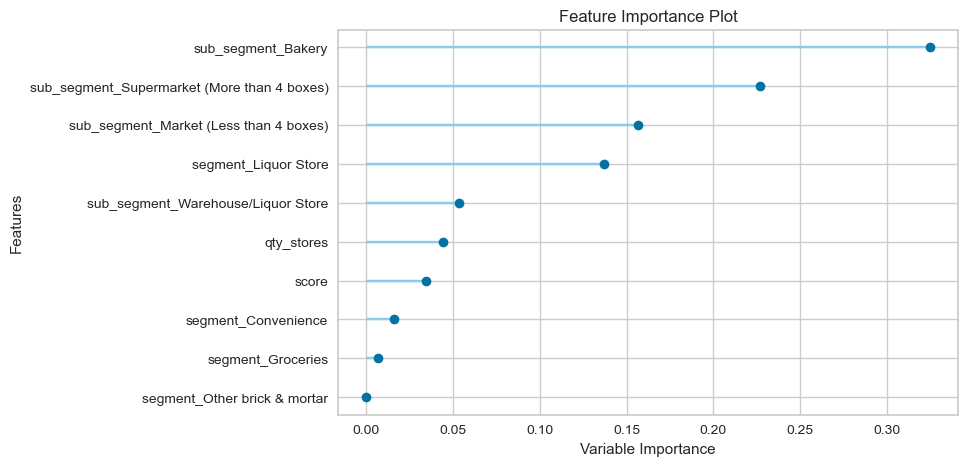

In [15]:
plot_model(model, plot='feature')

# Test

In [16]:
df_in_test_log = df_in_test.copy()

In [17]:
df_in_test_log['sells_volume'] = np.log10(df_in_test_log['sells_volume']+1)

In [18]:
validation_predictions = predict_model(best_model_2, data = df_in_test_log)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,0.4226,0.2773,0.5266,-0.3798,0.2386,0.5155


In [22]:
validation_predictions.head()

,index,id,segment,sub_segment,level_3,volume_log10,score,qty_stores,sells_volume,prediction_label
0,154029,61a82030d679f25039b550ce936a9a20,Groceries,Market (Less than 4 boxes),Store,1.489061,1.000000,23.0,1.489061,1.468010
1,154053,a48135d52c9a94fd7565ae50731c4125,Groceries,Market (Less than 4 boxes),Store,2.302284,7.000000,75.0,2.302284,1.468010
2,154059,a705e95aa4ff96e70247d3930c9866a1,Groceries,Market (Less than 4 boxes),Store,1.630069,33.857143,23.0,1.630069,1.468010
3,154135,5d5bc6d914f49edb9c0d827be81c3693,Groceries,Market (Less than 4 boxes),Store,0.884756,87.857140,11.0,0.884756,1.468010
4,154179,56416f297d7f14e5bbf162b59baf36a3,Liquor Store,Market (Less than 4 boxes),Store,2.653008,21.000000,5.0,3.128975,1.637546


In [23]:
final_model = finalize_model(model)

In [24]:
print(final_model)

Pipeline(memory=FastMemory(location=C:\Users\MARCIO~1\AppData\Local\Temp\joblib),
         steps=[('target_transformation',
                 TransformerWrapperWithInverse(transformer=TargetTransformer(estimator=PowerTransformer(standardize=False)))),
                ('numerical_imputer',
                 TransformerWrapper(include=['score', 'qty_stores'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 Tran...
                 TransformerWrapper(include=['segment', 'sub_segment'],
                                    transformer=OneHotEncoder(cols=['segment',
                                                                    'sub_segment'],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('transformation',
                 TransformerWrapper(transformer=PowerTransformer

# Save model

In [25]:
save_model(final_model,'model_final')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\MARCIO~1\AppData\Local\Temp\joblib),
          steps=[('target_transformation',
                  TransformerWrapperWithInverse(transformer=TargetTransformer(estimator=PowerTransformer(standardize=False)))),
                 ('numerical_imputer',
                  TransformerWrapper(include=['score', 'qty_stores'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  Tran...
                  TransformerWrapper(include=['segment', 'sub_segment'],
                                     transformer=OneHotEncoder(cols=['segment',
                                                                     'sub_segment'],
                                                               handle_missing='return_nan',
                                                               use_cat_names=True))),
                 ('transformation',
                  TransformerWrapper(transformer=P

##### Example of application

In [26]:
import pickle

In [28]:
prod_model = load_model('model_final')

Transformation Pipeline and Model Successfully Loaded


In [29]:
prediction = predict_model(prod_model, data=df_in_train)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,AdaBoost Regressor,19.9448,1143.6468,33.8178,-0.5212,1.9274,0.8230


In [30]:
prediction.head()

,segment,sub_segment,score,qty_stores,sells_volume,prediction_label
0,Groceries,Market (Less than 4 boxes),168.857147,6.0,80.613197,1.496368
1,Liquor Store,Market (Less than 4 boxes),148.428574,82.0,50.750401,1.635204
2,Groceries,Market (Less than 4 boxes),14.285714,19.0,40.520500,1.496368
3,Groceries,Market (Less than 4 boxes),1.000000,27.0,1.228400,1.514981
4,Groceries,Market (Less than 4 boxes),148.428574,82.0,16.886299,1.496368


In [44]:
print(best_model)

AdaBoostRegressor(random_state=123)


In [45]:
best_model

AdaBoostRegressor(random_state=123)